# Compare BLIP and ViT-GPT2

In [1]:
%%html
<style type='text/css'>
.CodeMirror{
font-family: JetBrains Mono;
</style>

In [44]:
import os
import torch
import pylab
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from torchvision import transforms
from models.blip import blip_decoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer, util
from torchvision.transforms.functional import InterpolationMode

from transformers import pipeline, VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_path = os.path.join('..','data_visual','flickr30k')
img_sz = 640

df = pd.read_csv(os.path.join(data_path,'results.csv'),sep='|', nrows=1000)
df = df[['image_name',' comment']]
df.columns = ['img','caption']
df

,img,caption
0,1000092795.jpg,Two young guys with shaggy hair look at their...
1,1000092795.jpg,"Two young , White males are outside near many..."
2,1000092795.jpg,Two men in green shirts are standing in a yard .
3,1000092795.jpg,A man in a blue shirt standing in a garden .
4,1000092795.jpg,Two friends enjoy time spent together .
...,...,...
995,1067675215.jpg,A man lies on a mat in a parking lot between ...
996,1067675215.jpg,A shirtless man is laying down in the middle ...
997,1067675215.jpg,A man laying down in middle of street during ...
998,1067675215.jpg,A man in blue shorts lays down outside in a p...


## Perform Caption Generation

In [3]:
#Load ViT-GPT2
vit_gpt2 = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

vit_gpt2.to(device)

#Load BLIP
if not os.path.isfile(pretrained_path:=os.path.join('..','checkpoints','blip_base.pth')):
    pretrained_path = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth'

blip = blip_decoder(pretrained=pretrained_path, image_size=img_sz, vit='base')
blip.eval()
blip = blip.to(device)


reshape position embedding from 196 to 1600
load checkpoint from ..\checkpoints\blip_base.pth


In [4]:
def load_img(img_path, img_sz, scl=3):
    
    raw_image = Image.open(img_path).convert('RGB')
    w,h = raw_image.size
    
    transform = transforms.Compose([
        transforms.Resize((img_sz,img_sz),interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ]) 
    image = transform(raw_image).unsqueeze(0).to(device)   
    return image

def get_blip(img:str):
    with torch.no_grad():
        caption = blip.generate(load_img(img_path=os.path.join(data_path,'img',img),
                                 img_sz=img_sz), sample=False, top_p=0.9, max_length=20, min_length=5) 
    return caption[0]

def get_vit(img:str):

    max_length = 20
    num_beams = 4
    gen_kwargs = {"max_length": max_length, "num_beams": num_beams}
    
    img = Image.open(os.path.join(data_path,'img',img))
    
    if img.mode != "RGB":
        img = img.convert(mode="RGB")

    pixel_values = feature_extractor(images=[img], return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)

    output_ids = vit_gpt2.generate(pixel_values, **gen_kwargs)

    preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    preds = [pred.strip() for pred in preds]
    return preds[0]


In [5]:
df['blip_caption'] = df['img'].apply(get_blip)
df['vit_caption']  = df['img'].apply(get_vit)

df.to_csv('sex.csv', index=False)

## Perform text similarity

In [6]:
tm = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

df = pd.read_csv('sex.csv')

df['blip_simil'] = [str(util.pytorch_cos_sim(
                            tm.encode(str(a),convert_to_tensor=True),
                            tm.encode(str(b), convert_to_tensor=True)).tolist()[0][0]) 
                    for a,b in zip(df['caption'],df['blip_caption'])]


df['vit_simil'] = [str(util.pytorch_cos_sim(
                            tm.encode(str(a),convert_to_tensor=True),
                            tm.encode(str(b), convert_to_tensor=True)).tolist()[0][0]) 
                    for a,b in zip(df['caption'],df['vit_caption'])]


df['blip_tfidf'] = [((k:=TfidfVectorizer().fit_transform([a,b]))*k.T).A[0,1]
                   for a,b in zip(df['caption'],df['blip_caption'])]

df['vit_tfidf'] = [((k:=TfidfVectorizer().fit_transform([a,b]))*k.T).A[0,1]
                   for a,b in zip(df['caption'],df['vit_caption'])]


df.to_csv('sex2.csv', index=False)



# Visualise Results

In [46]:
df = pd.read_csv('sex2.csv')

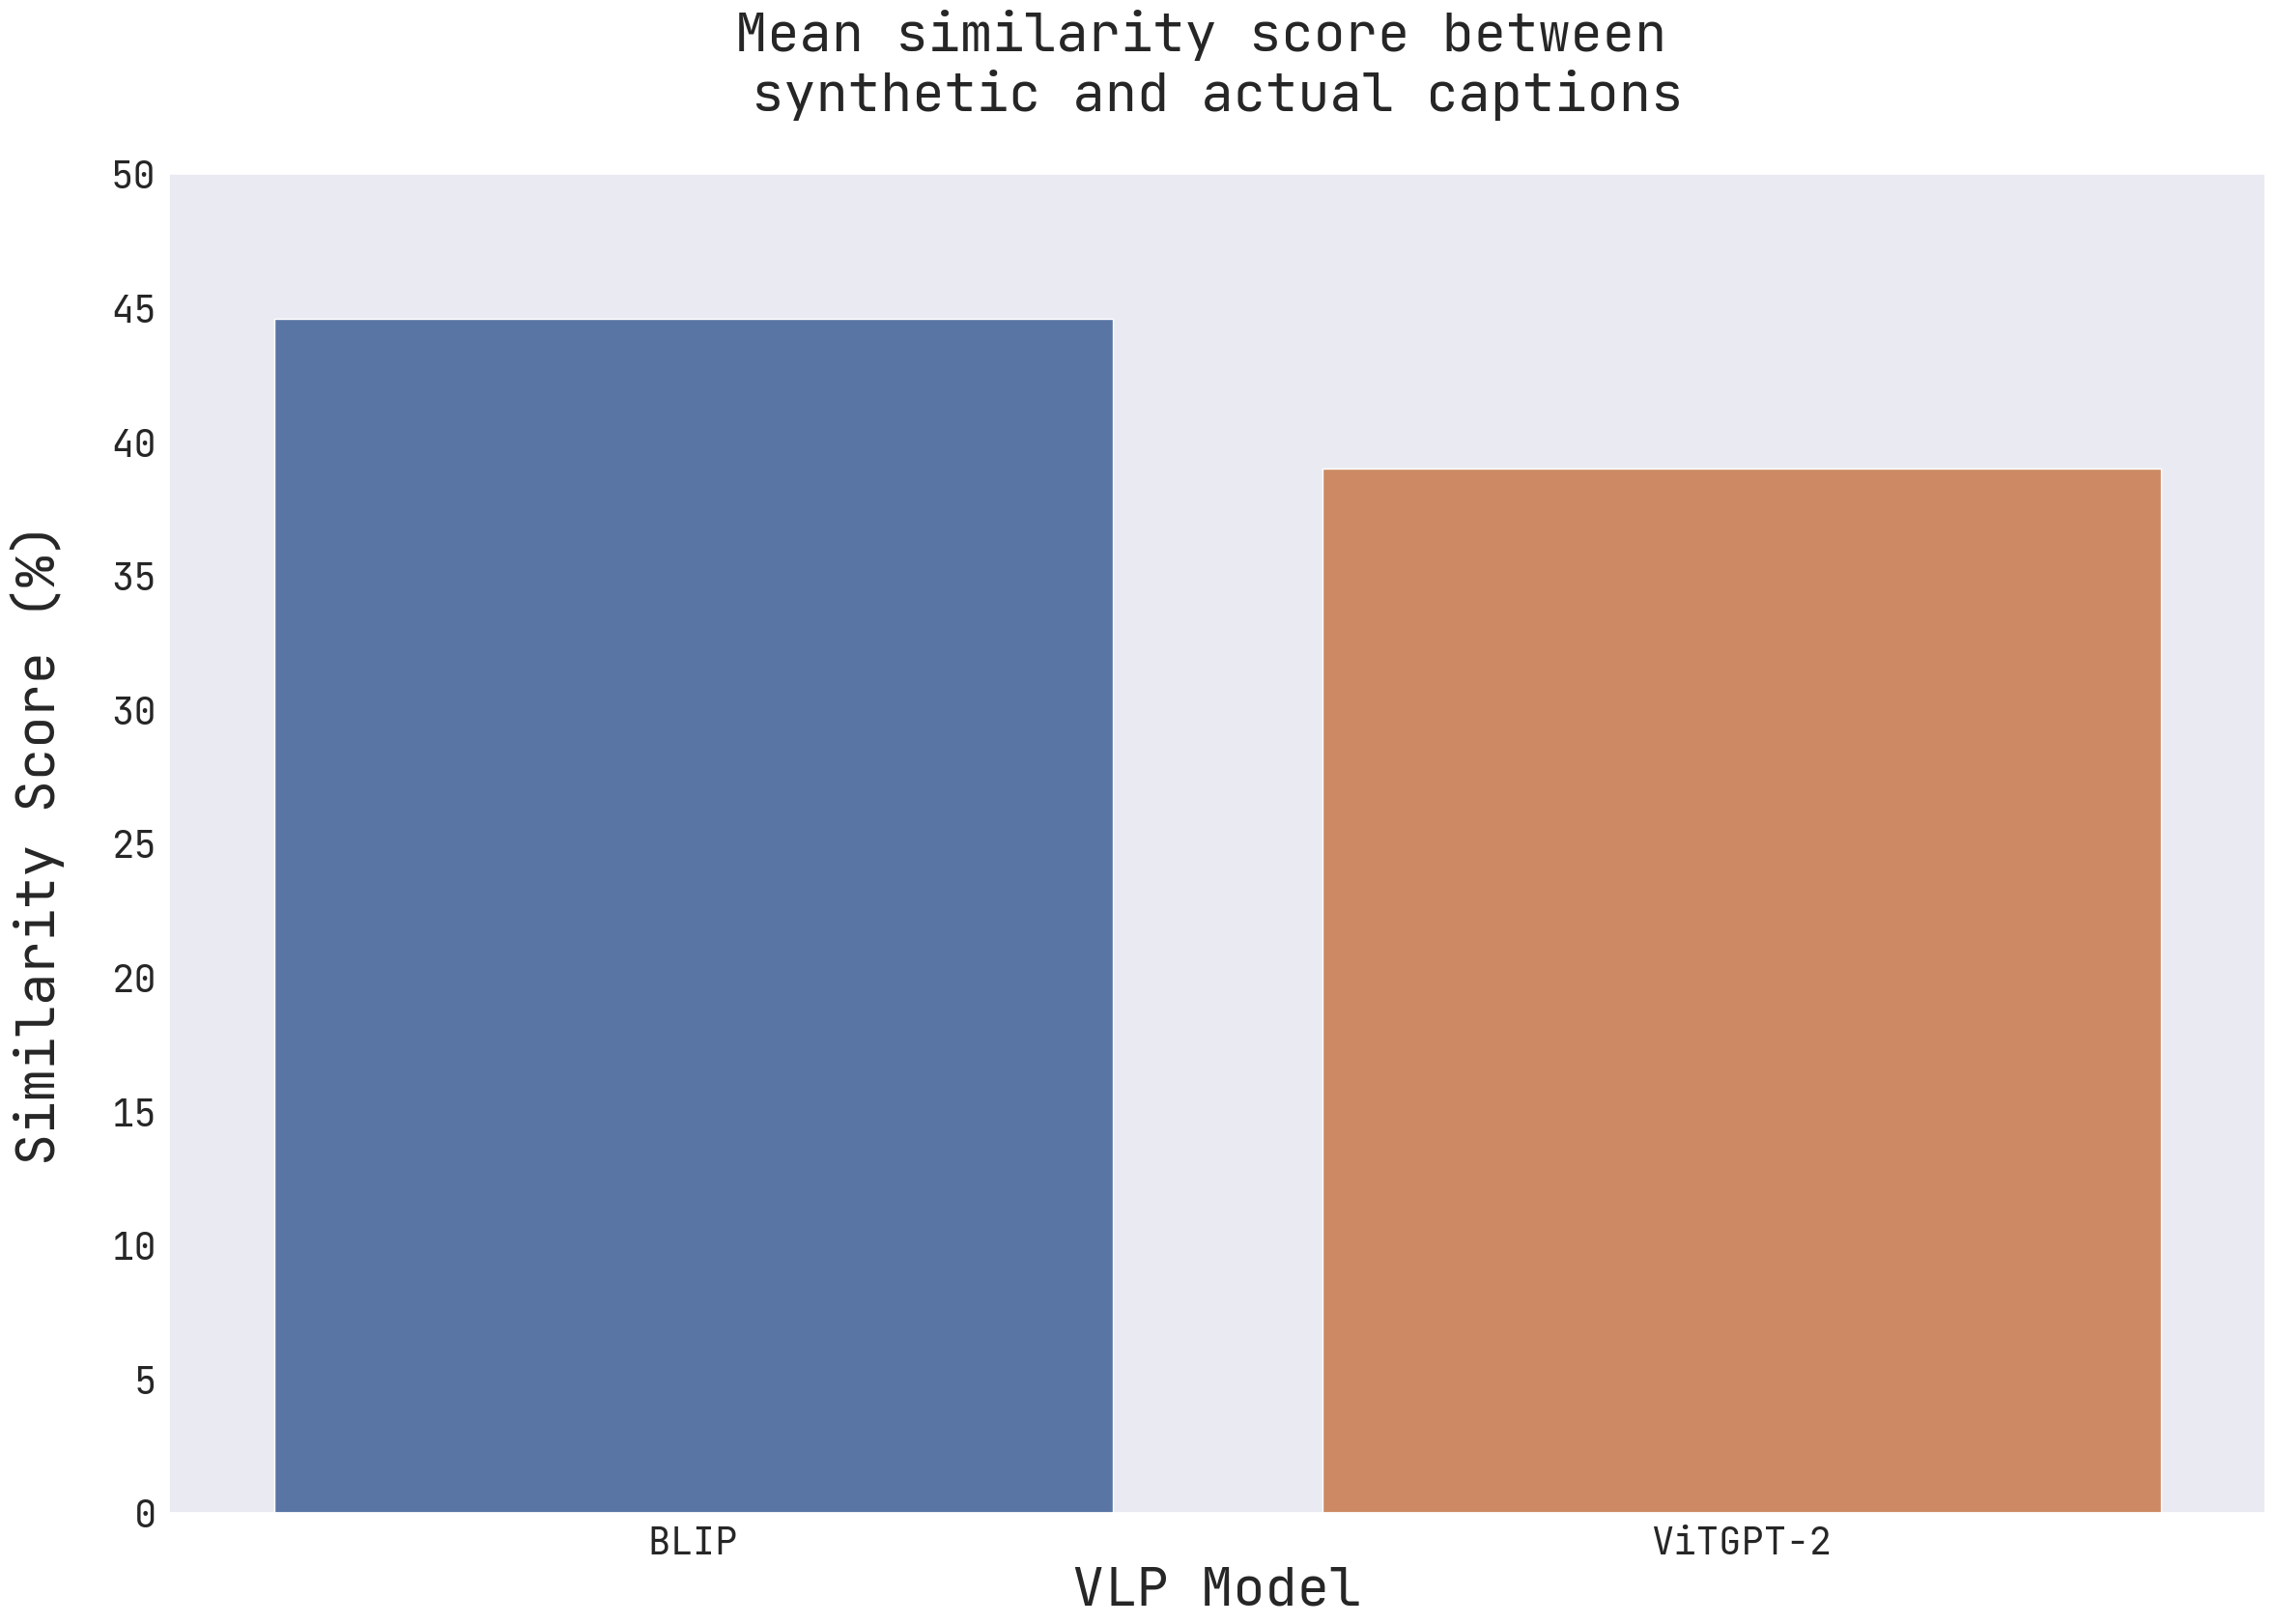

In [58]:
sns.set(rc={'figure.figsize':(28,18)})
sns.set(font="JetBrains Mono")

a = pd.to_numeric(k:=df['blip_simil'])[k!=0].mean()
b = pd.to_numeric(k:=df['vit_simil'] )[k!=0].mean()

ax = sns.barplot(data=[[a],[b]],
                estimator=lambda x: x[0]*100)

ax.set_xticklabels(['BLIP','ViTGPT-2'])
ax.grid(False)
ax.set_ylabel('Similarity Score (%)',fontsize=40)
ax.yaxis.set_label_coords(-0.05,0.5)
ax.tick_params(labelsize=28)
ax.set_xlabel('VLP Model',fontsize=40)
ax.set_yticks(range(0,55,5))
ax.set_title('Mean similarity score between \nsynthetic and actual captions\n',fontsize=40)

pylab.savefig('simil.jpg', bbox_inches='tight', pad_inches=1)

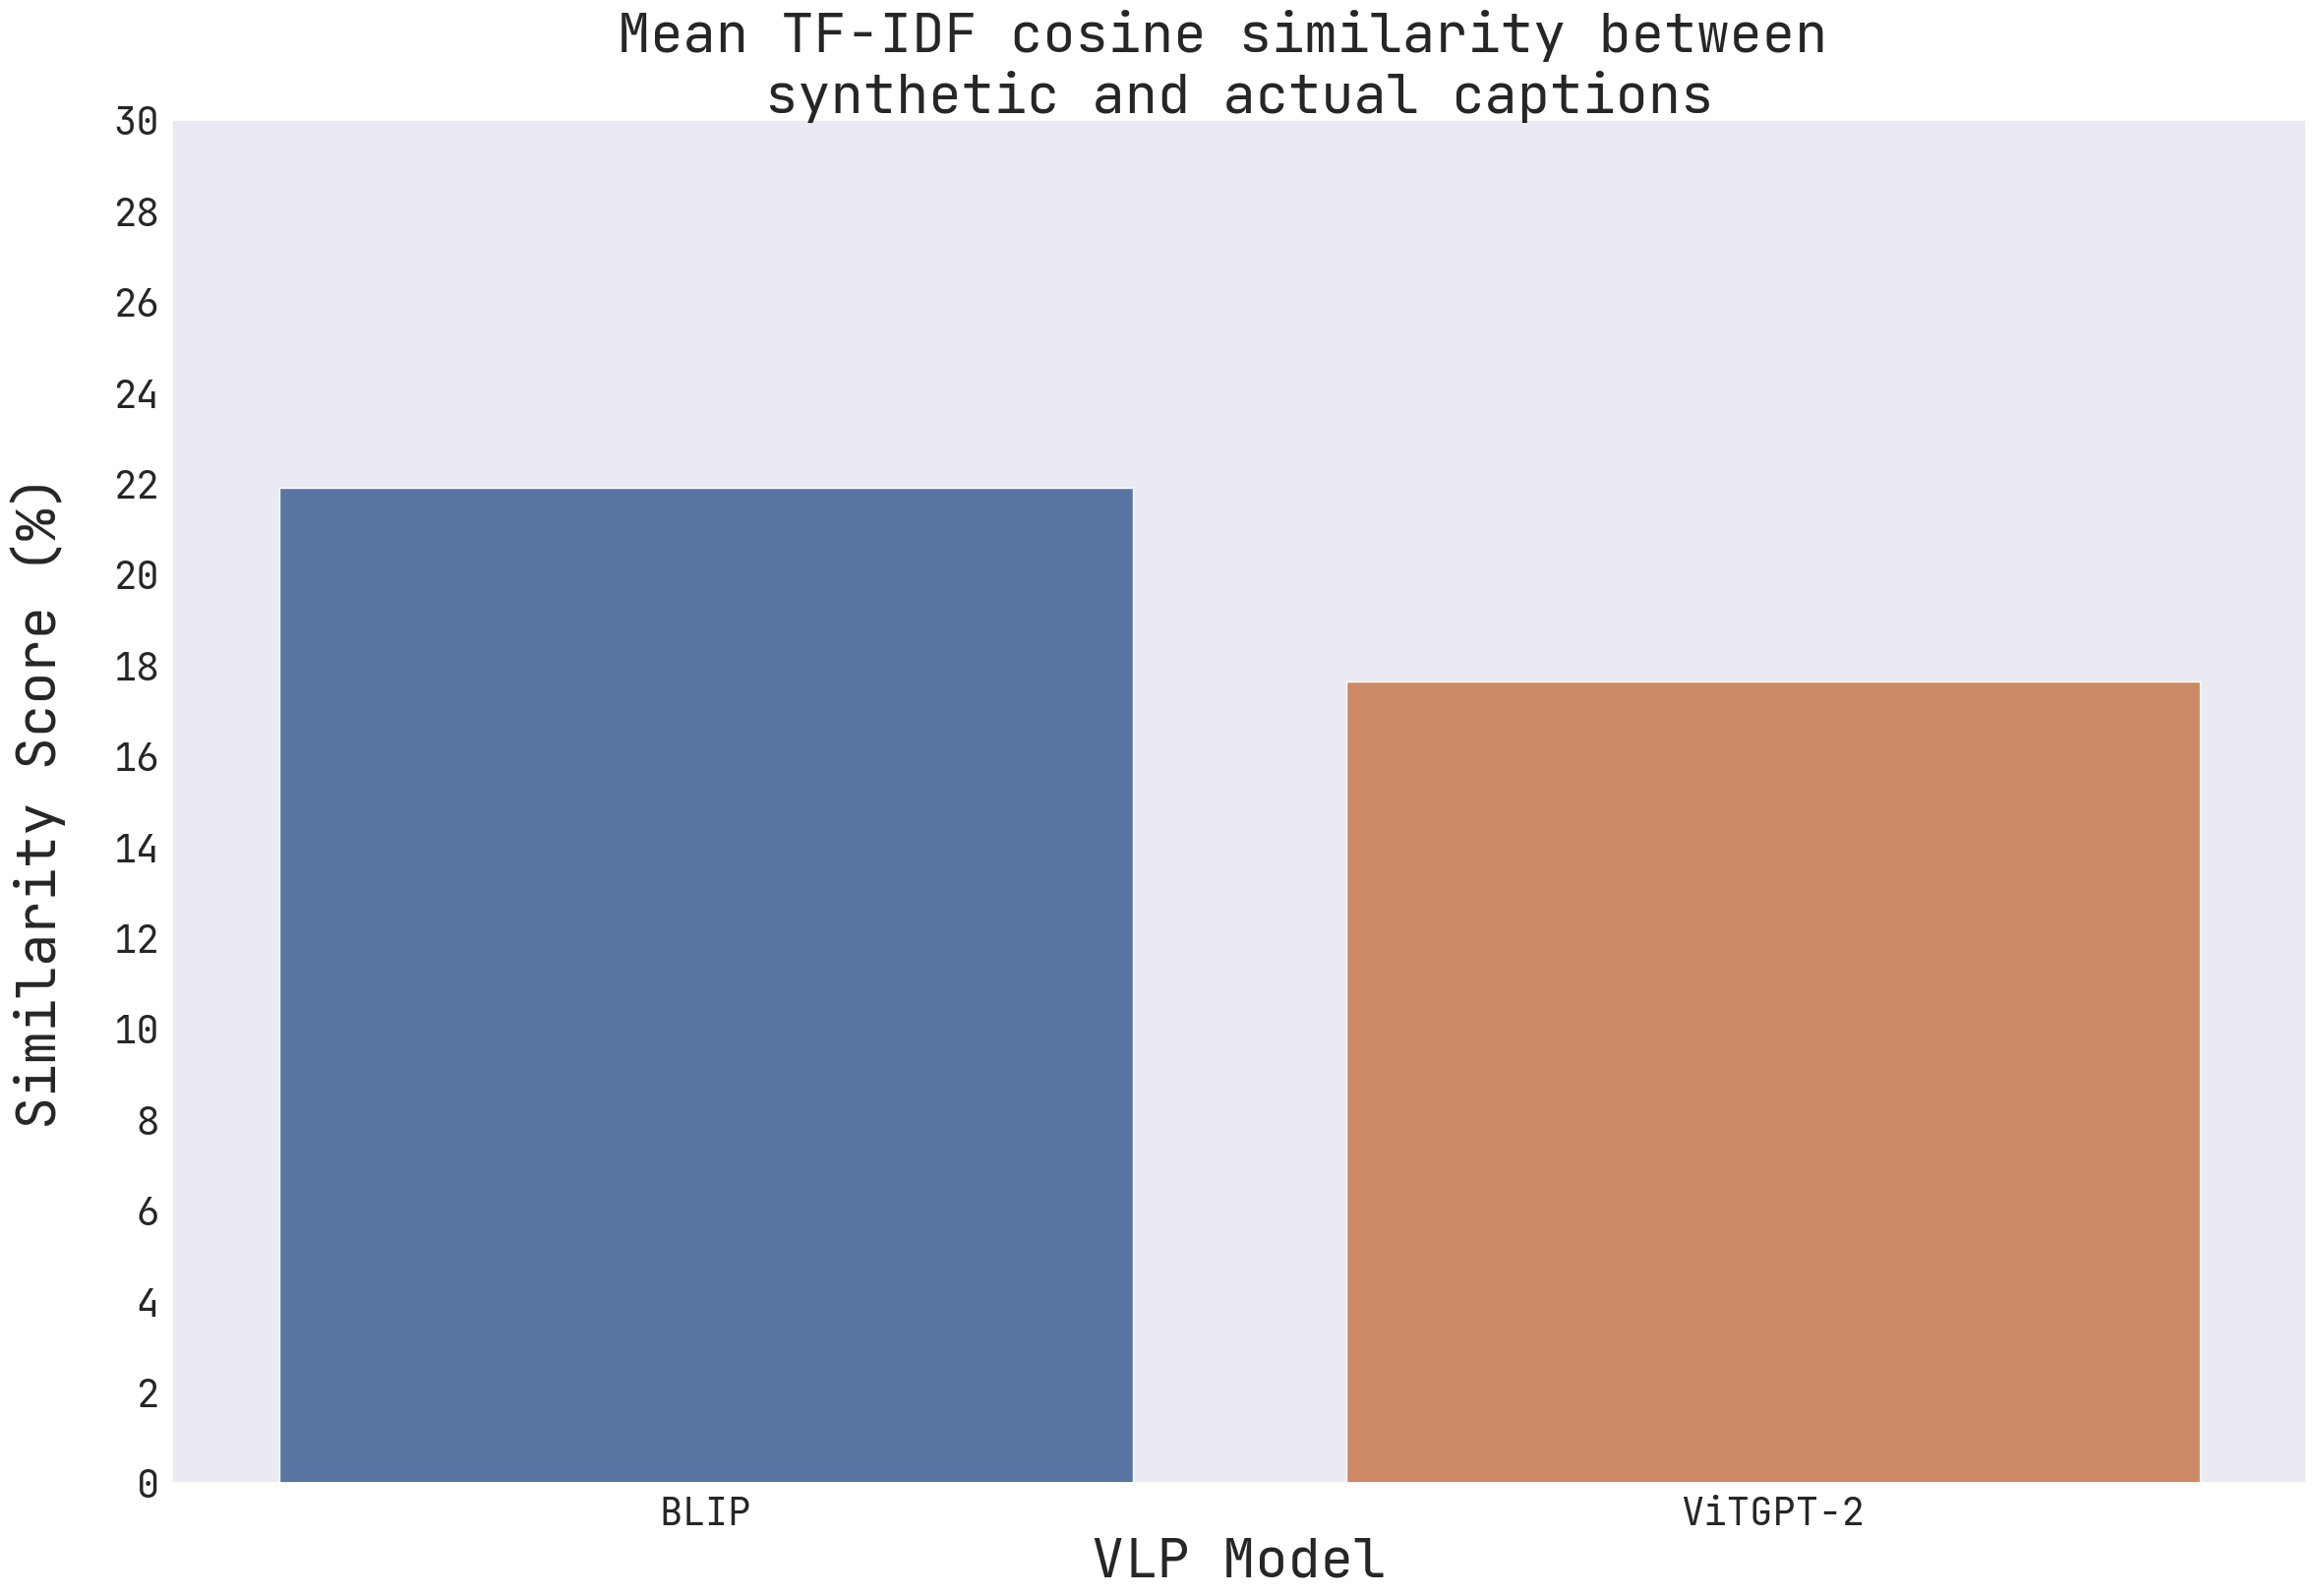

In [62]:
sns.set(rc={'figure.figsize':(28,18)})
sns.set(font="JetBrains Mono")

a = pd.to_numeric(k:=df['blip_tfidf'])[k!=0].mean()
b = pd.to_numeric(k:=df['vit_tfidf'] )[k!=0].mean()

ax = sns.barplot(data=[[a],[b]],
                estimator=lambda x: x[0]*100)

ax.set_xticklabels(['BLIP','ViTGPT-2'])
ax.grid(False)
ax.set_ylabel('Similarity Score (%)',fontsize=40)
ax.yaxis.set_label_coords(-0.05,0.5)
ax.tick_params(labelsize=28)
ax.set_xlabel('VLP Model',fontsize=40)
ax.set_yticks(range(0,32,2))
ax.set_title('Mean TF-IDF cosine similarity between \nsynthetic and actual captions',fontsize=40)
pylab.savefig('tf-idf.jpg', bbox_inches='tight', pad_inches=1)

In [78]:
mean = ((a+b)/2)

0.21906116711432458